In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,C2532,239,아파트,강원도,국민임대,49.20,19,7.0,A,11346000,116090,0.0,1.0,166.0,146.0
2948,C2532,239,아파트,강원도,국민임대,51.08,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2949,C2532,239,아파트,강원도,국민임대,51.73,34,7.0,A,14005000,142310,0.0,1.0,166.0,146.0
2950,C2532,239,아파트,강원도,국민임대,51.96,114,7.0,A,14005000,142310,0.0,1.0,166.0,146.0


In [61]:
dict = {}
for i in list(train.columns) :
    dict[i] = train[i].value_counts().shape[0]

pd.DataFrame(dict, index=["Unique Count"]).transpose()

,Unique Count
단지코드,423
총세대수,351
임대건물구분,2
지역,16
공급유형,10
전용면적,679
전용면적별세대수,403
공가수,48
자격유형,15
임대보증금,957


In [62]:
categorial_variable = ["임대건물구분", "지역", "공급유형", "자격유형"]
continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
                      "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수",
                      "단지내주차면수"]
target_variable = ["등록차량수"]

In [63]:
null_variable = ["임대보증금", "임대료",
                      "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수"]

train.isnull().sum()
# 임대보증금, 임대료, 도보 10분거리 내 지하철역 수(환승노선 수 반영), 도보 10분거리 내 버스정류장 수

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

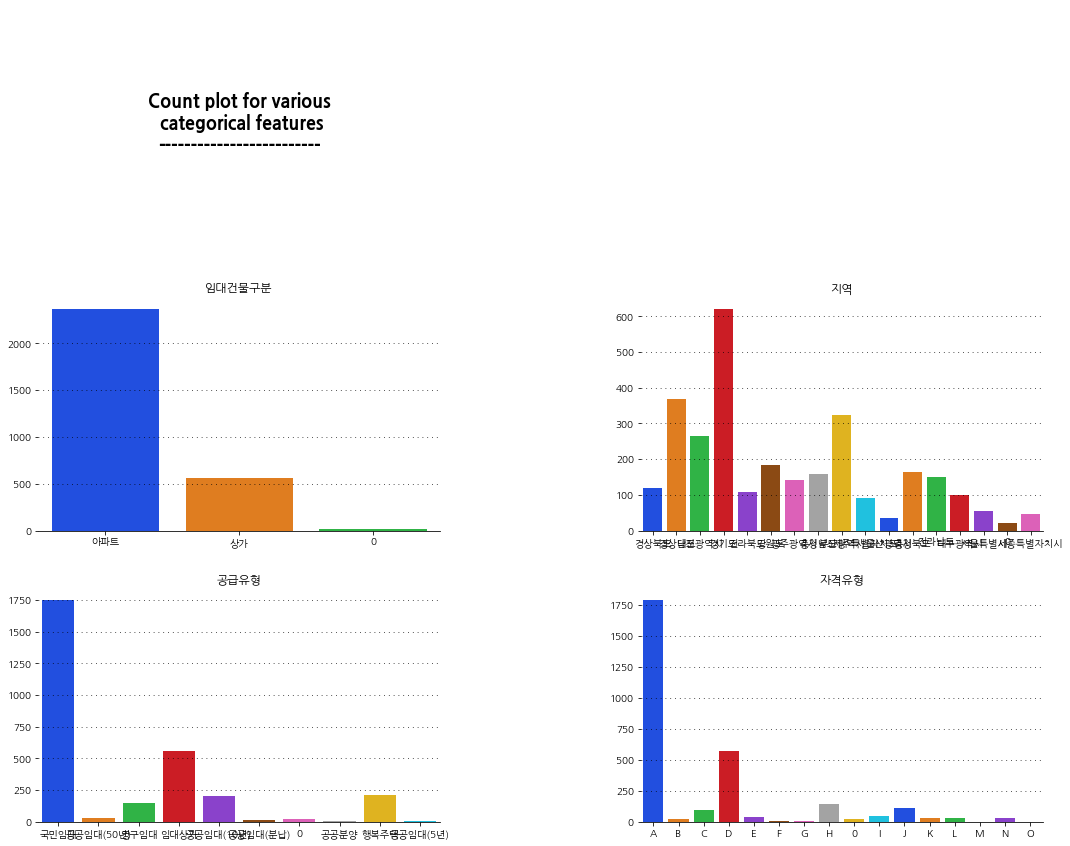

In [73]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,2)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

background_color = "#ffffff"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)

ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5, 0.5, 'Count plot for various\n categorical features\n-------------------------',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=18, fontweight='bold',
        fontfamily='NanumGothic', color='#000000')

ax1.set_title('임대건물구분')
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=train, x='임대건물구분', palette='bright')
ax1.set_xlabel("")
ax1.set_ylabel("")

ax2.set_title('지역')
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2, data=train, x='지역', palette='bright')
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3.set_title('공급유형')
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3, data=train, x='공급유형', palette='bright')
ax3.set_xlabel("")
ax3.set_ylabel("")

ax4.set_title('자격유형')
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4, data=train, x='자격유형', palette='bright')
ax4.set_xlabel("")
ax4.set_ylabel("")

for s in ["top", 'left', "right"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
 

Text(0, 0.5, '')

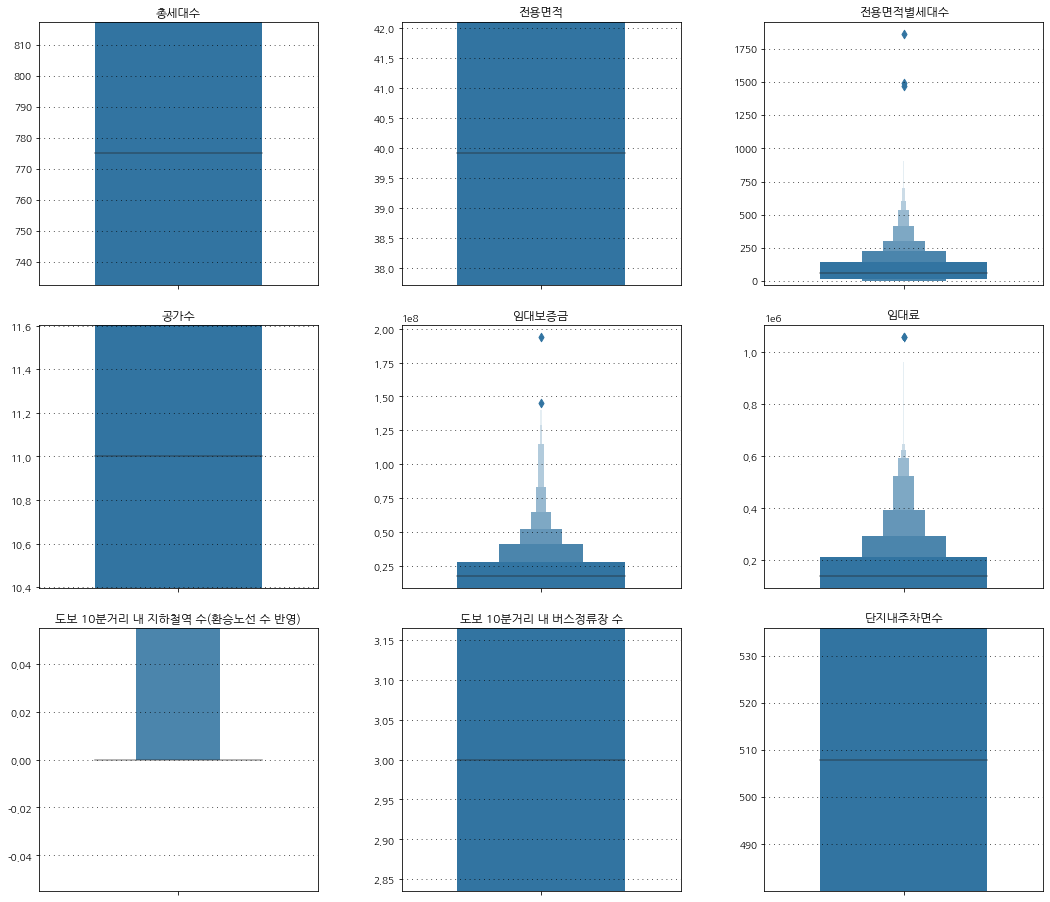

In [80]:
#continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
#                      "도보 10분거리 내 지하철역 수(환승노선 수 반영)", "도보 10분거리 내 버스정류장 수",
#                      "단지내주차면수"]


fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.3, hspace=0.15)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])
ax6 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[2,0])
ax8 = fig.add_subplot(gs[2,1])
ax9 = fig.add_subplot(gs[2,2])

ax1.set_title('총세대수')
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=train['총세대수'],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

ax2.set_title('전용면적')
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=train['전용면적'],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

ax3.set_title('전용면적별세대수')
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=train['전용면적별세대수'],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

ax4.set_title('공가수')
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=train['공가수'],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

ax5.set_title('임대보증금')
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=train['임대보증금'],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

ax6.set_title('임대료')
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax6,y=train['임대료'],width=0.6)
ax6.set_xlabel("")
ax6.set_ylabel("")

ax7.set_title('도보 10분거리 내 지하철역 수(환승노선 수 반영)')
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax7,y=train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'],width=0.6)
ax7.set_xlabel("")
ax7.set_ylabel("")

ax8.set_title('도보 10분거리 내 버스정류장 수')
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax8,y=train['도보 10분거리 내 버스정류장 수'],width=0.6)
ax8.set_xlabel("")
ax8.set_ylabel("")

ax9.set_title('단지내주차면수')
ax9.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax9,y=train['단지내주차면수'],width=0.6)
ax9.set_xlabel("")
ax9.set_ylabel("")

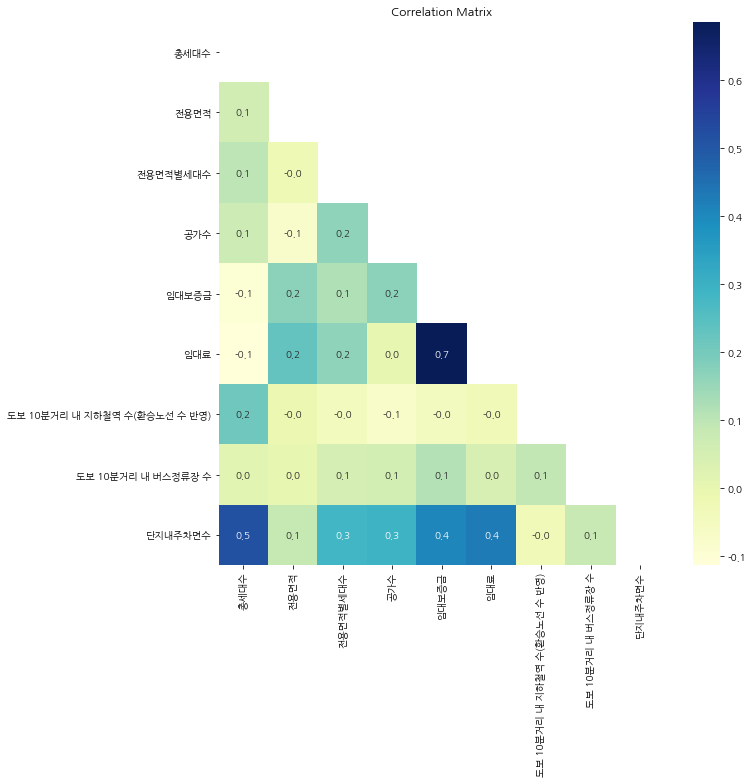

In [89]:
df_corr = train[continious_variable].corr().transpose()

fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
ax0=fig.add_subplot(gs[0,0])

color_palette = ["#5833ff","#da8829"]
mask = np.triu(np.ones_like(df_corr))
ax0.set_title('Correlation Matrix')
sns.heatmap(df_corr, mask=mask, fmt=".1f", annot=True, cmap='YlGnBu')
plt.show()

#강한 상관관계 : 임대료 - 임대보증금
#중간 상관관계 : 단지내주차면수 - (총세대수, 전용면적별세대수, 공가수, 임대보증금, 임대료)

In [148]:
from sklearn.preprocessing import RobustScaler

def pre_processing(x):
    x = x.fillna(0)
    x[x['임대료'] == '-'] = 0
    x[x['임대보증금'] == '-'] = 0
    x[['임대료', '임대보증금']] = x[['임대료', '임대보증금']].astype('int64')
    x.isnull().sum()
    
    x = pd.get_dummies(x, columns=categorial_variable, drop_first=True)
    scaler = RobustScaler()
    x[continious_variable] = scaler.fit_transform(x[continious_variable])
    return x

df = train

df = pd.get_dummies(df, columns=categorial_variable, drop_first=True)
differ_variables = ['공급유형_공공임대(5년)', '자격유형_B', '자격유형_F', '자격유형_O', '지역_서울특별시', '공급유형_공공분양']

X_train = pre_processing(train.drop(['등록차량수', '단지코드'], axis=1))
y_train = df['등록차량수']
X_test = pre_processing(test.drop('단지코드', axis=1))
for c in differ_variables:
    X_test[c] = 0
id_code = test['단지코드']

print(X_train.columns)
print(X_test.columns)

Index(['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수',
       '임대건물구분_상가', '임대건물구분_아파트', '지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도',
       '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_서울특별시',
       '지역_세종특별자치시', '지역_울산광역시', '지역_전라남도', '지역_전라북도', '지역_제주특별자치도', '지역_충청남도',
       '지역_충청북도', '공급유형_공공분양', '공급유형_공공임대(10년)', '공급유형_공공임대(50년)',
       '공급유형_공공임대(5년)', '공급유형_공공임대(분납)', '공급유형_국민임대', '공급유형_영구임대', '공급유형_임대상가',
       '공급유형_행복주택', '자격유형_A', '자격유형_B', '자격유형_C', '자격유형_D', '자격유형_E', '자격유형_F',
       '자격유형_G', '자격유형_H', '자격유형_I', '자격유형_J', '자격유형_K', '자격유형_L', '자격유형_M',
       '자격유형_N', '자격유형_O'],
      dtype='object')
Index(['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료',
       '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수',
       '임대건물구분_상가', '임대건물구분_아파트', '지역_강원도', '지역_경기도', '지역_경상남도', '지역_경상북도',
       '지역_광주광역시', '지역_대구광역시', '지역_대전광역시', '지역_부산광역시', '지역_세종특별자치시',
       '지역_울산광역시',

In [157]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
import sklearn

gbr = GradientBoostingRegressor()
rfr = RandomForestRegressor(n_estimators=100, max_depth=25, min_samples_leaf=1, min_samples_split=4)
ridge = Ridge()
model = rfr


params = {
    'n_estimators':[100],
    'max_depth':[25],
    'min_samples_leaf':[1],
    'min_samples_split':[4]
}
# grid = GridSearchCV(rfr, param_grid=params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid.fit(X_train, y_train)
# print(grid.best_params_, grid.best_score_)
model.fit(X_train, y_train)
pred = model.predict(X_test)

result = pd.DataFrame(id_code)
result['num'] = pred
result.columns = ['code','num']
result.to_csv('./result/result1.csv')
# gbr: 72.57647194273466
# rfr: 19.73668358714044
# {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100} -62.07652539964124
